In [1]:
import numpy as np
import torch 
import torchvision
from PIL import Image
import torch.optim as optim 
import matplotlib.pyplot as plt
import tensorflow as tf 
from io import BytesIO
import requests

%matplotlib inline


In [2]:
use_cuda = torch.cuda.is_available()

if use_cuda:
    print("Cuda is available")
else:
    print("CPU is on, because cuda is not available")

Cuda is available


In [3]:
#Load and Preprocess Image
from torchvision import datasets, models, transforms 

def load_image(img_path):
    image = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    image = transform(image)[:3, :, :].unsqueeze(0)
    return image

content = load_image("../input/style-transfer-image-and-style/MarsRover.jpg")
style = load_image("../input/style-transfer-image-and-style/Vassily_Kandinsky_1913_-_Composition_7.jpg")




In [4]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

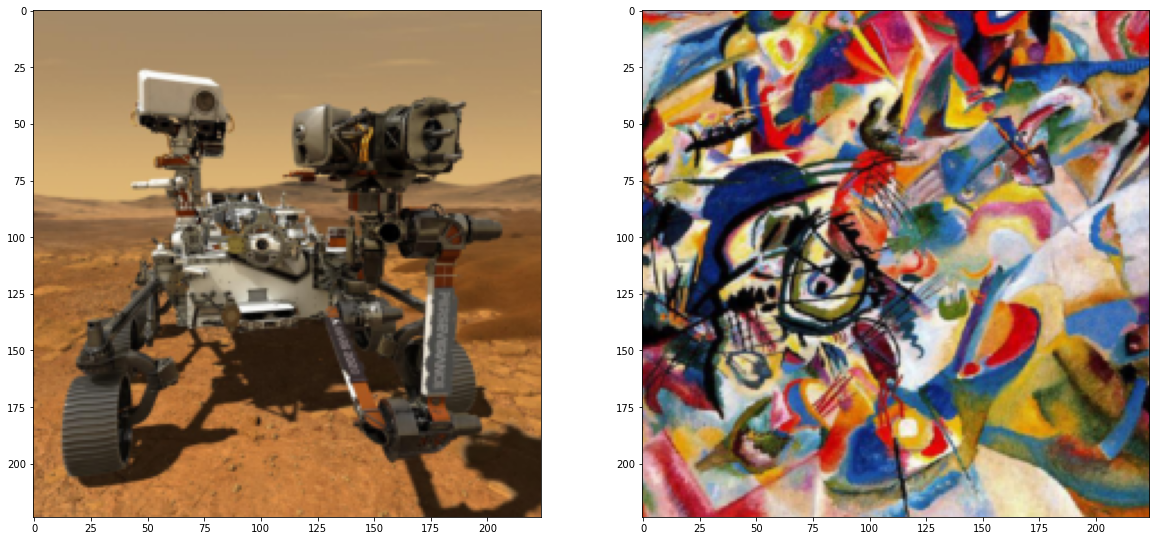

In [5]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [6]:
vgg16 = models.vgg16(pretrained = True).features
if use_cuda:
    vgg16.cuda()

for param in vgg16.parameters():
    param.requires_grad = False

print(vgg16)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_s

In [7]:
def get_features(model, image, layers = None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features



In [8]:
def gram_matrix(tensor):
    
    batch_size, d, h, w = tensor.size()
    
    #Change from 3d to a 2d shape
    tensor = tensor.view(d, h*w)
    gram_matrix = torch.mm(tensor, tensor.t())
    
    return gram_matrix
    


In [28]:
if use_cuda:
    content, style = content.cuda(), style.cuda()

content_features = get_features(vgg16, content)
style_features = get_features(vgg16, style)

style_gram_matrixes = {}
for layer in style_features:
    
    gram = gram_matrix(style_features[layer])
    style_gram_matrixes[layer] = gram

    
target = content.clone().requires_grad_(True)
if use_cuda:
    target = target.cuda()
    



In [29]:
style_weights = {"conv1_1": 1,
                 "conv2_1": 0.8,
                 "conv3_1": 0.5,
                 "conv4_1": 0.3,
                 "conv5_1": 0.1}

content_loss_alpha = 1
style_loss_beta = 1e10



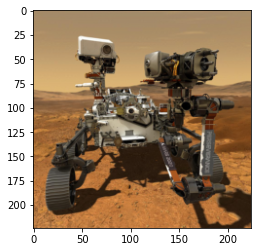

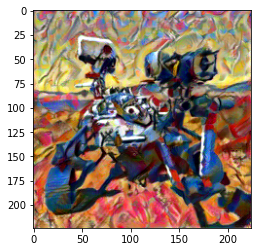

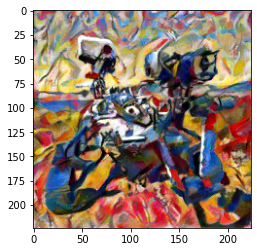

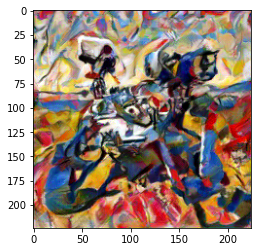

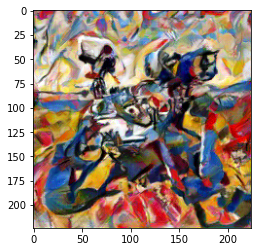

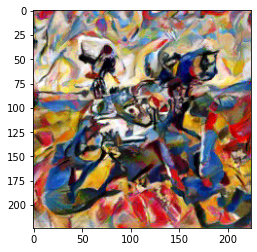

In [30]:
print_every = 4000
optimizer = optim.Adam([target], lr = 0.003)

steps = 20000
for ii in range(1 + steps + 1):
    
    #content loss
    #style loss
    #target loss
    
    #Calculate the content loss
    content_value = content_features['conv4_2']
    target_features = get_features(vgg16, target)
    target_content = target_features["conv4_2"]
    
    content_loss = torch.mean((target_content - content_value) ** 2)
    
    #Calculate the style loss
    
    style_loss = 0
    for layer in style_weights:
        
        target_feature = target_features[layer]
        target_gram_matrix = gram_matrix(target_feature)
        
        
        style_gram_matrix = style_gram_matrixes[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        
        style_loss += layer_style_loss
        
    #Calculate the total loss
    
    total_loss = (content_loss_alpha * content_loss + style_loss_beta * style_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % print_every == 0:
        plt.imshow(im_convert(target))
        plt.show()
        
        
    

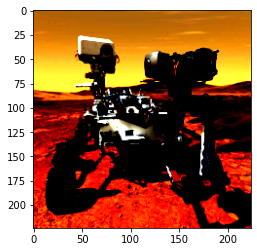

In [37]:
content = content.squeeze().cpu().detach().numpy()
plt.imshow(np.transpose(content, (1, 2, 0)))

In [ ]:
target = target.squeeze()
plt.imshow(np.transpose(target, (1, 2, 0)))